#### 住房月租金预测大数据赛（付费竞赛）

http://www.dcjingsai.com/common/cmpt/%E4%BD%8F%E6%88%BF%E6%9C%88%E7%A7%9F%E9%87%91%E9%A2%84%E6%B5%8B%E5%A4%A7%E6%95%B0%E6%8D%AE%E8%B5%9B%EF%BC%88%E4%BB%98%E8%B4%B9%E7%AB%9E%E8%B5%9B%EF%BC%89_%E8%B5%9B%E4%BD%93%E4%B8%8E%E6%95%B0%E6%8D%AE.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib import style
style.use("ggplot")
%matplotlib inline

### 1.读取数据

In [117]:
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

In [118]:
train.columns

Index(['时间', '小区名', '小区房屋出租数量', '楼层', '总楼层', '房屋面积', '房屋朝向', '居住状态', '卧室数量',
       '厅的数量', '卫的数量', '出租方式', '区', '位置', '地铁线路', '地铁站点', '距离', '装修情况', '月租金'],
      dtype='object')

In [119]:
columns = ["time","department","rent_num","floor","total_floor","square","direction","living_state","num_bedroom",
          "num_living_room","num_bath_room","rent_type","district","position","metro_line","station","distance","decoration","month_rent"]

In [120]:
train.columns = columns

In [108]:
test.columns = ["id"] + columns[:-1]

#### 1.1 数据质量探索

In [7]:
train.shape,test.shape

((196539, 19), (56279, 19))

#### 空值探索

In [8]:
train.isnull().sum(axis=0)/train.shape[0]

time               0.000000
department         0.000000
rent_num           0.005093
floor              0.000000
total_floor        0.000000
square             0.000000
direction          0.000000
living_state       0.897537
num_bedroom        0.000000
num_living_room    0.000000
num_bath_room      0.000000
rent_type          0.876717
district           0.000158
position           0.000158
metro_line         0.533029
station            0.533029
distance           0.533029
decoration         0.905912
month_rent         0.000000
dtype: float64

In [9]:
test.isnull().sum(axis=0)/test.shape[0]

id                 0.000000
time               0.000000
department         0.000000
rent_num           0.000391
floor              0.000000
total_floor        0.000000
square             0.000000
direction          0.000000
living_state       0.920343
num_bedroom        0.000000
num_living_room    0.000000
num_bath_room      0.000000
rent_type          0.911672
district           0.000178
position           0.000178
metro_line         0.529238
station            0.529238
distance           0.529238
decoration         0.925247
dtype: float64

* 居住状态:living_state 基本为空
* 出租方式:rent_type 基本为空
* 装修情况:decoration 基本为空
-----
跟附近地铁情况的特征，空缺率为50%左右
* metro_line         
* station            
* distance          

##### 数据类型探索

In [10]:
train.dtypes

time                 int64
department           int64
rent_num           float64
floor                int64
total_floor        float64
square             float64
direction           object
living_state       float64
num_bedroom          int64
num_living_room      int64
num_bath_room        int64
rent_type          float64
district           float64
position           float64
metro_line         float64
station            float64
distance           float64
decoration         float64
month_rent         float64
dtype: object

##### unique情况探索

In [11]:
train.nunique()

time                  3
department         5547
rent_num            154
floor                 3
total_floor          55
square             7848
direction            64
living_state          3
num_bedroom          12
num_living_room       7
num_bath_room         9
rent_type             2
district             14
position            152
metro_line            5
station             118
distance           1155
decoration            6
month_rent          419
dtype: int64

In [12]:
test.nunique()

id                 56279
time                   1
department          3804
rent_num             118
floor                  3
total_floor           55
square              5276
direction             54
living_state           3
num_bedroom           11
num_living_room        8
num_bath_room          8
rent_type              2
district              14
position             149
metro_line             5
station              115
distance            1121
decoration             6
dtype: int64

##### 数据倾斜情况

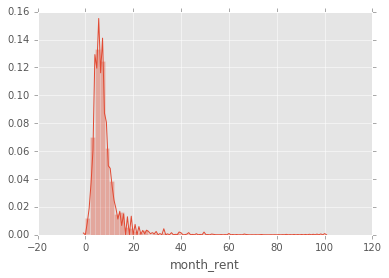

In [13]:
sns.distplot(train["month_rent"])

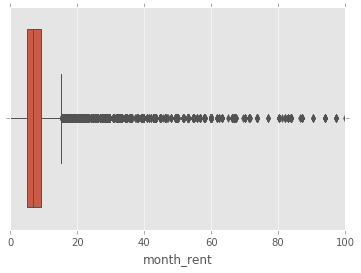

In [14]:
sns.boxplot(train["month_rent"])

###### 结论：
月租金右偏，可以将偏的数据当作是异常数据

In [15]:
train[train["month_rent"]>=20].shape[0] / train.shape[0]

0.03561634077714856

### 2.单变量数据分析

In [16]:
train.head()

,time,department,rent_num,floor,total_floor,square,direction,living_state,num_bedroom,num_living_room,num_bath_room,rent_type,district,position,metro_line,station,distance,decoration,month_rent
0,1,3072,0.128906,2,0.236364,0.008628,东南,NaN,1,1,1,NaN,11.0,118.0,2.0,40.0,0.764167,NaN,5.602716
1,1,3152,0.132812,1,0.381818,0.017046,东,NaN,1,0,0,NaN,10.0,100.0,4.0,58.0,0.709167,NaN,16.977929
2,1,5575,0.042969,0,0.290909,0.010593,东南,NaN,2,1,2,NaN,12.0,130.0,5.0,37.0,0.572500,NaN,8.998302
3,1,3103,0.085938,2,0.581818,0.019199,南,NaN,3,2,2,NaN,7.0,90.0,2.0,63.0,0.658333,NaN,5.602716
4,1,5182,0.214844,0,0.545455,0.010427,东北,NaN,2,1,1,NaN,3.0,31.0,NaN,NaN,NaN,NaN,7.300509


##### 2.1 小区分析

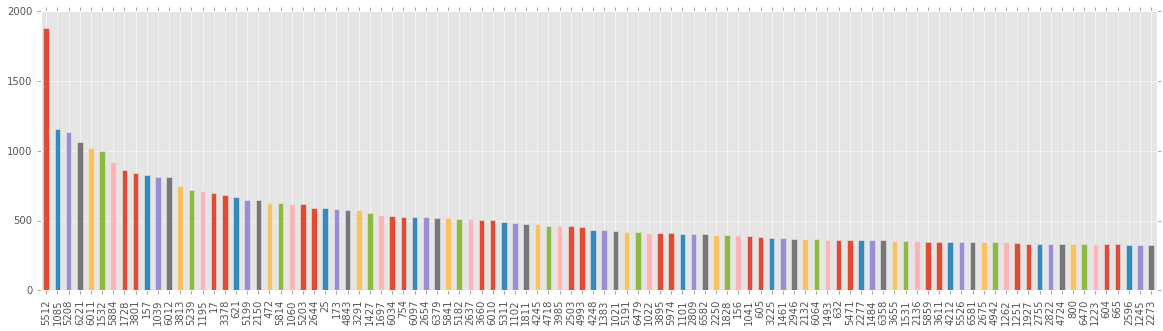

In [17]:
fig,ax = plt.subplots(figsize=(20,5))
train["department"].value_counts().head(100).plot("bar",ax=ax)

##### 出租数量探索

In [18]:
train["rent_num"].value_counts().sort_index().head(10)

0.007812    5454
0.011719    5962
0.015625    6137
0.019531    6152
0.023438    5940
0.027344    5894
0.031250    5663
0.035156    5705
0.039062    5477
0.042969    5058
Name: rent_num, dtype: int64

##### 等差规律：

In [19]:
rent_num = train["rent_num"].unique().tolist()
rent_num = sorted(rent_num)
diff_ls = [rent_num[i+1] - rent_num[i] for i in range(0,len(rent_num)-1,1)]

In [20]:
rent_num[:5]

[0.0078125, 0.01171875, 0.015625, 0.01953125, 0.0234375]

In [21]:
pd.Series(diff_ls).value_counts()

0.003906    108
0.007812     16
0.011719     10
0.027344      5
0.066406      2
0.023438      2
0.031250      2
0.050781      1
0.039062      1
0.035156      1
0.273438      1
0.082031      1
0.042969      1
0.015625      1
dtype: int64

In [22]:
for i in pd.Series(diff_ls).value_counts().index:
    print(i,"--->",i/0.00390625)

0.00390625 ---> 1.0
0.0078125 ---> 2.0
0.01171875 ---> 3.0
0.02734375 ---> 7.0
0.06640625 ---> 17.0
0.0234375 ---> 6.0
0.03125 ---> 8.0
0.05078125 ---> 13.0
0.0390625 ---> 10.0
0.03515625 ---> 9.0
0.2734375 ---> 70.0
0.08203125 ---> 21.0
0.04296875 ---> 11.0
0.015625 ---> 4.0


In [23]:
def getRentNum(rent_num):
    if str(rent_num)=='nan':
        return np.nan
    else:
        return round((rent_num - 0.0078125)/0.00390625,2) + 1

In [24]:
train["real_rent_num"] = train["rent_num"].map(getRentNum)
test["real_rent_num"] = test["rent_num"].map(getRentNum)

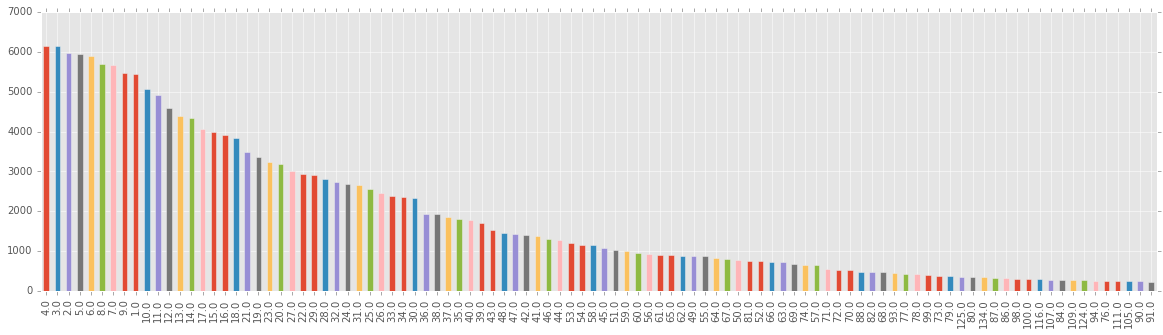

In [25]:
fig,ax = plt.subplots(figsize=(20,5))
train["real_rent_num"].value_counts().head(100).plot("bar",ax=ax)

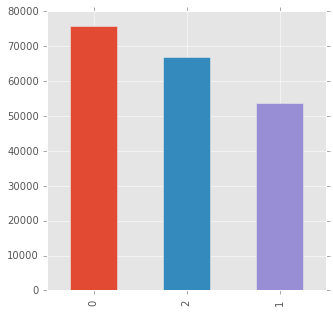

In [26]:
fig,ax = plt.subplots(figsize=(5,5))
train["floor"].value_counts().plot("bar",ax=ax)

##### 所在楼层

In [27]:
floor_num = train["total_floor"].unique().tolist()
floor_num = sorted(floor_num)
floor_diff_ls = [floor_num[i+1] - floor_num[i] for i in range(0,len(floor_num)-1,1)]

In [28]:
list(set(floor_diff_ls))

[0.018181818181818188,
 0.018181818181818202,
 0.018181818181818216,
 0.018181818181818146,
 0.018181818181818174,
 0.01818181818181816,
 0.018181818181818105,
 0.01818181818181827,
 0.018181818181818132,
 0.018181818181818243,
 0.018181818181818077,
 0.036363636363636265,
 0.01818181818181818,
 0.0181818181818183,
 0.01818181818181802]

In [29]:
def getTotalFloor(total_floor):
    if str(total_floor)=='nan':
        return np.nan
    else:
        return round((total_floor - 0.0) / 0.018181818181818188,2)+ 1

In [30]:
train["real_total_floor"] = train["total_floor"].map(getTotalFloor)
test["real_total_floor"] = test["total_floor"].map(getTotalFloor)

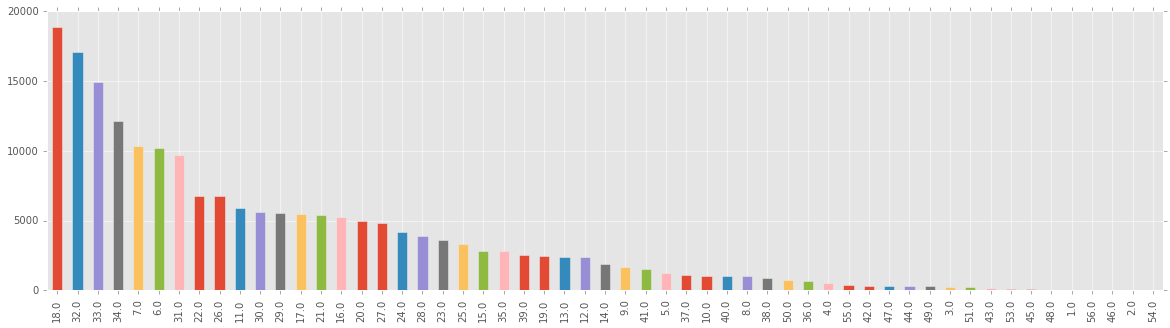

In [31]:
fig,ax = plt.subplots(figsize=(20,5))
train["real_total_floor"].value_counts().head(100).plot("bar",ax=ax)

##### 查看约束即 ----> 所在楼层大于总楼层

In [32]:
train[train["real_total_floor"]< train["floor"]][["floor","total_floor","real_total_floor"]]

,floor,total_floor,real_total_floor


In [33]:
test[test["real_total_floor"]< test["floor"]][["floor","total_floor","real_total_floor"]]

,floor,total_floor,real_total_floor


##### 面积

####

In [34]:
square = train["square"].unique().tolist()
square = sorted(square)
square_diff_ls = [square[i+1] - square[i] for i in range(0,len(square)-1,1)]

In [35]:
min(list(set(square_diff_ls)))

1.655081098957123e-06

In [36]:
for i in list(set(square_diff_ls)):
    print(i,'---->',i/min(list(set(square_diff_ls))))

5.461767626613323e-05 ----> 33.000000000331205
0.00013075140681895192 ----> 79.00000000080915
0.0019860973187686426 ----> 1200.0000000121415
0.5091029460443561 ----> 307600.0000031087
0.0001092353525322734 ----> 66.0000000006666
0.00010923535253228034 ----> 66.0000000006708
0.0009715326050976497 ----> 587.0000000059324
8.771929824560182e-05 ----> 53.00000000052825
5.461767626615405e-05 ----> 33.00000000034378
0.00021847070506455374 ----> 132.0000000013374
8.771929824560876e-05 ----> 53.000000000532445
3.3101621979475526e-05 ----> 20.00000000020124
3.310162197947672e-05 ----> 20.00000000020196
3.3101621979476394e-05 ----> 20.000000000201762
0.00019695465077787522 ----> 119.00000000119486
3.3101621979482465e-05 ----> 20.000000000205432
8.77192982456157e-05 ----> 53.00000000053664
1.1585567692803944e-05 ----> 7.0000000000628875
0.0264349553128103 ----> 15972.000000161403
1.1585567692810883e-05 ----> 7.00000000006708
6.620324395894411e-05 ----> 40.00000000039829
0.0001423369745117628 ---->

In [37]:
train["square"].min(),test["square"].min()

(0.0, 0.0)

In [38]:
def getSquare(square):
    if str(square)=='nan':
        return square
    else:
        return int((square - 0)/1.655081098957123e-06/100)

In [39]:
train["real_square"] = train["square"].map(getSquare)
test["real_square"] = test["square"].map(getSquare)

#### 朝向

In [40]:
train["direction"].value_counts()

南              54770
东南             54359
东              31962
西南             17470
北              10428
西               9799
西北              5179
南 北             4003
东北              3287
东南 南             848
东 东南             823
东 西              741
南 西南             423
东 南              401
东南 西南            240
南 西              215
东南 西北            152
西南 西             122
东 北              103
西 西北              87
南 西南 北            86
西 北               84
西南 西北             74
东南 南 西南           70
东南 东北             69
东 东北              67
西北 北              59
南 西北              59
北 东北              57
东南 西              57
               ...  
东 南 西 北           35
东 西北              35
南 东               24
西北 东北             23
东 东南 南            18
南 东北              16
东南 南 北            13
东南 西南 西北          11
东 东南 西南           11
南 西 北             11
东 南 西             11
东 南 北              8
东 西 北              7
南 西南 西             7
东 西北 北             6
西 西北 北             5
北 南          

###### 居住状态

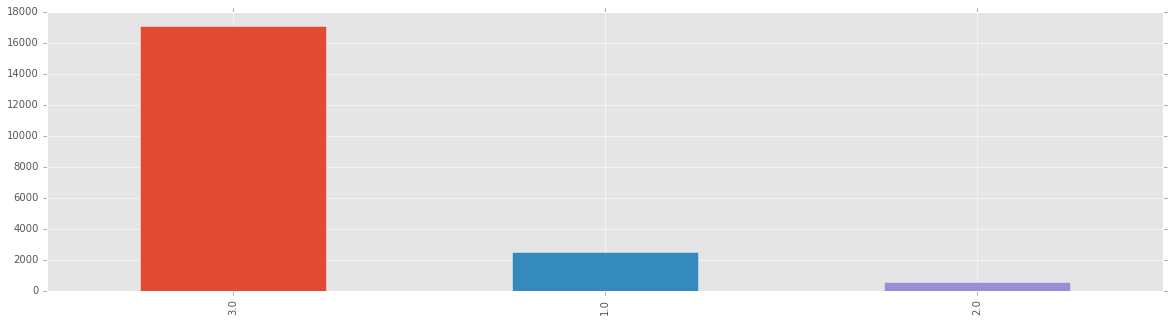

In [41]:
fig,ax = plt.subplots(figsize=(20,5))
train["living_state"].value_counts().head(100).plot("bar",ax=ax)

###### 卫数

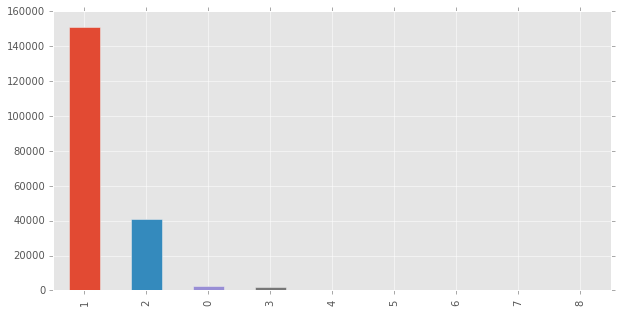

In [42]:
fig,ax = plt.subplots(figsize=(10,5))
train["num_bath_room"].value_counts().head(100).plot("bar",ax=ax)

##### 卧室

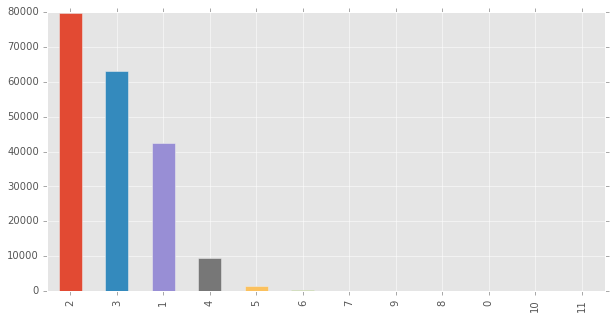

In [43]:
fig,ax = plt.subplots(figsize=(10,5))
train["num_bedroom"].value_counts().head(100).plot("bar",ax=ax)

###### 客厅数量

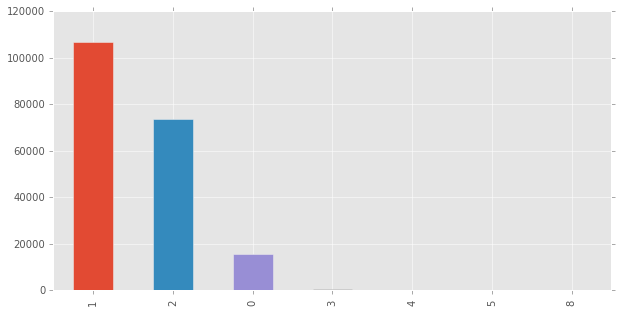

In [44]:
fig,ax = plt.subplots(figsize=(10,5))
train["num_living_room"].value_counts().head(100).plot("bar",ax=ax)

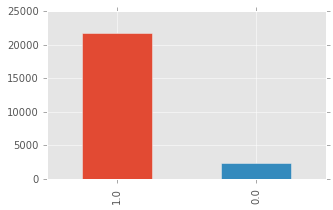

In [45]:
fig,ax = plt.subplots(figsize=(5,3))
train["rent_type"].value_counts().head(100).plot("bar",ax=ax)

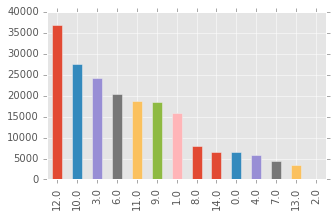

In [46]:
fig,ax = plt.subplots(figsize=(5,3))
train["district"].value_counts().head(100).plot("bar",ax=ax)

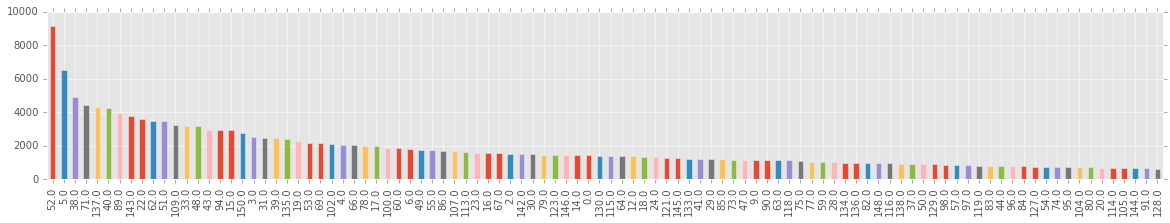

In [47]:
fig,ax = plt.subplots(figsize=(20,3))
train["position"].value_counts().head(100).plot("bar",ax=ax)

In [48]:
train["metro_line"].fillna("nan").value_counts()

nan    104761
5.0     26577
4.0     20002
1.0     17189
3.0     15375
2.0     12635
Name: metro_line, dtype: int64

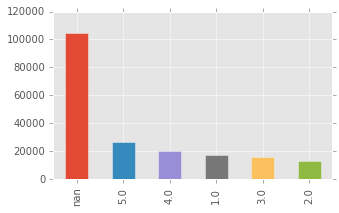

In [49]:
fig,ax = plt.subplots(figsize=(5,3))
train["metro_line"].fillna("nan").value_counts().head(100).plot("bar",ax=ax)

In [50]:
train["distance"].value_counts()

0.535000    1031
0.718333     889
0.228333     751
0.400000     558
0.514167     511
0.356667     486
0.420833     472
0.364167     469
0.515000     468
0.345833     467
0.346667     442
0.850833     420
0.554167     418
0.234167     409
0.759167     398
0.755833     368
0.859167     366
0.357500     363
0.009167     355
0.315833     355
0.377500     336
0.614167     334
0.724167     314
0.840833     298
0.360833     280
0.675000     278
0.336667     278
0.699167     277
0.217500     269
0.118333     258
            ... 
0.081667       2
0.096667       2
0.734167       2
0.218333       2
0.047500       2
0.097500       2
0.103333       2
0.258333       2
0.100833       2
0.004167       2
0.065000       2
0.108333       2
0.195833       2
0.794167       2
0.021667       2
0.136667       1
0.077500       1
0.078333       1
0.180000       1
0.083333       1
0.179167       1
0.114167       1
0.030000       1
0.089167       1
0.002500       1
0.054167       1
0.134167       1
0.135833      

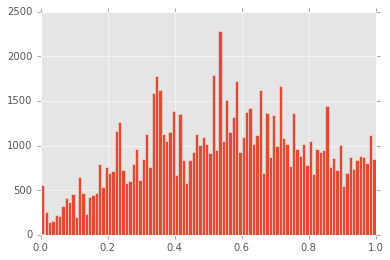

In [51]:
train["distance"].hist(bins=100)

In [52]:
distance_num = train["distance"].unique().tolist()
distance_num = sorted(distance_num)
distance_num_diff_ls = [distance_num[i+1] - distance_num[i] for i in range(0,len(distance_num)-1,1)]

In [53]:
list(set(distance_num_diff_ls))

[0.011666666666666659,
 0.01416666666666666,
 0.0050000000000000044,
 0.004166666666666652,
 0.006666666666666654,
 0.0008333333333333526,
 0.003333333333333355,
 0.0016666666666666496,
 0.0008333333333332971,
 0.00833333333333336,
 0.005833333333333357,
 0.004166666666666541,
 nan,
 0.004166666666666596,
 nan,
 0.004999999999999977,
 0.002500000000000009,
 0.004166666666666707,
 0.002499999999999891,
 0.0033333333333333826,
 0.0016666666666666635,
 0.004166666666666666,
 0.0024999999999999467,
 0.004166666666666874,
 0.0016666666666666644,
 0.0025000000000000022,
 0.0016666666666666653,
 0.002500000000000016,
 0.004166666666666669,
 0.0025000000000000577,
 0.001666666666666667,
 0.0016666666666666683,
 0.0016666666666666219,
 0.0008333333333331305,
 0.018333333333333333,
 0.0008333333333332416,
 0.0016666666666666705,
 0.00666666666666671,
 0.0008333333333334081,
 0.0008333333333333248,
 0.015833333333333338,
 0.0024999999999999745,
 0.005000000000000032,
 0.0016666666666666774,
 0.00

In [54]:
for i in list(set(distance_num_diff_ls)):
    print(i,'--->',i/min(list(set(distance_num_diff_ls))))

0.011666666666666659 ---> 14.000000000003398
0.01416666666666666 ---> 17.000000000004132
0.0050000000000000044 ---> 6.0000000000014655
0.004166666666666652 ---> 5.000000000001199
0.006666666666666654 ---> 8.000000000001933
0.0008333333333333526 ---> 1.0000000000002665
0.003333333333333355 ---> 4.000000000000999
0.0016666666666666496 ---> 2.0000000000004663
0.0008333333333332971 ---> 1.0000000000001998
0.00833333333333336 ---> 10.000000000002466
0.005833333333333357 ---> 7.000000000001732
0.004166666666666541 ---> 5.000000000001066
nan ---> nan
0.004166666666666596 ---> 5.000000000001132
nan ---> nan
0.004999999999999977 ---> 6.000000000001433
0.002500000000000009 ---> 3.000000000000741
0.004166666666666707 ---> 5.000000000001266
0.002499999999999891 ---> 3.0000000000005995
0.0033333333333333826 ---> 4.000000000001033
0.0016666666666666635 ---> 2.000000000000483
0.004166666666666666 ---> 5.000000000001216
0.0024999999999999467 ---> 3.000000000000666
0.004166666666666874 ---> 5.000000000

In [55]:
def getDistance(distance):
    if str(distance)=='nan':
        return np.nan
    else:
        return (distance - 0.0016666666666666668) / 0.0008333333333331305

In [56]:
train["real_distance"] = train["distance"].map(getDistance)
test["real_distance"] = test["distance"].map(getDistance)

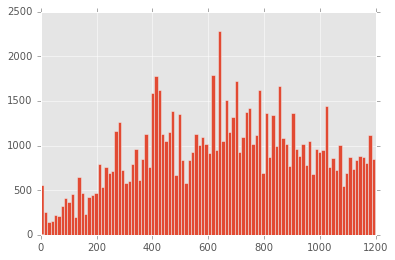

In [57]:
train["real_distance"].hist(bins=100)

### 3.多变量分析
--------------
分析各变量和目标变量的关系

##### 散点图

In [58]:
train.columns

Index(['time', 'department', 'rent_num', 'floor', 'total_floor', 'square',
       'direction', 'living_state', 'num_bedroom', 'num_living_room',
       'num_bath_room', 'rent_type', 'district', 'position', 'metro_line',
       'station', 'distance', 'decoration', 'month_rent', 'real_rent_num',
       'real_total_floor', 'real_square', 'real_distance'],
      dtype='object')

In [59]:
discrete_cols = ["rent_num","total_floor","square","distance","real_rent_num","real_total_floor","real_square","real_distance"]

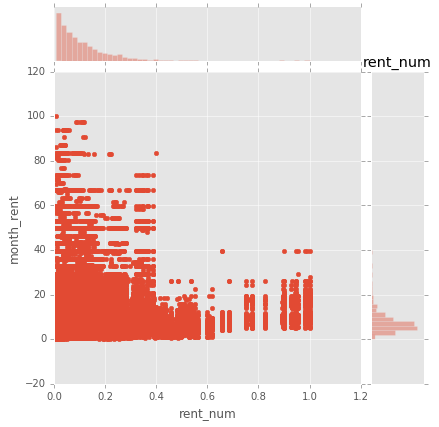

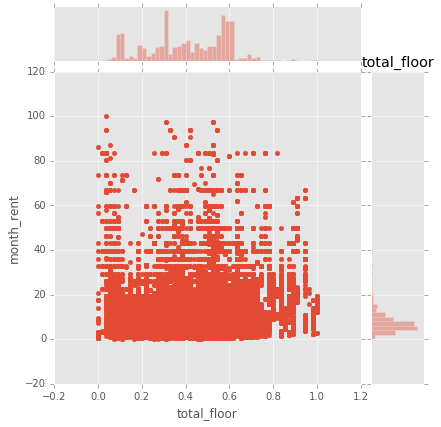

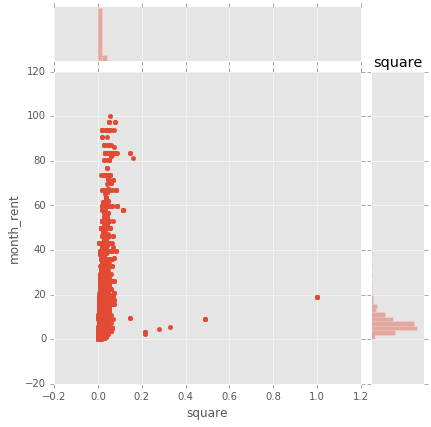

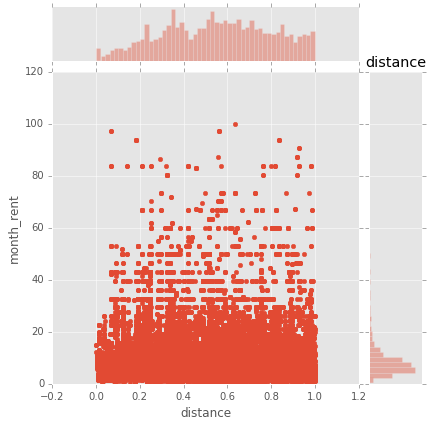

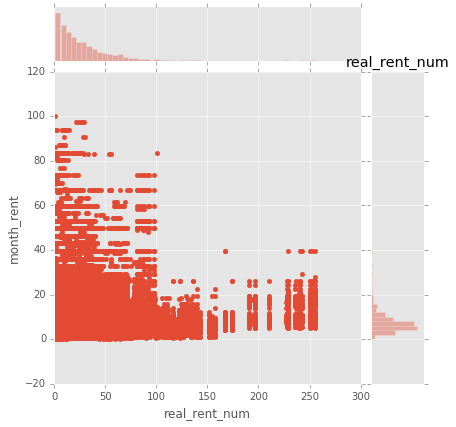

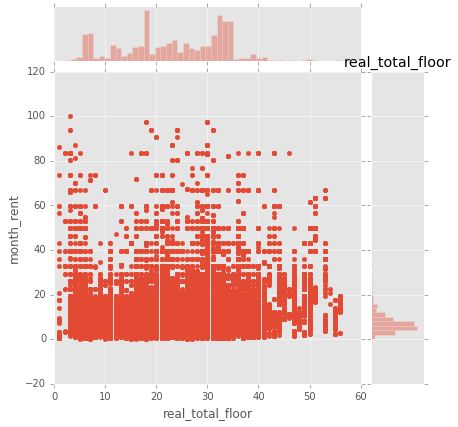

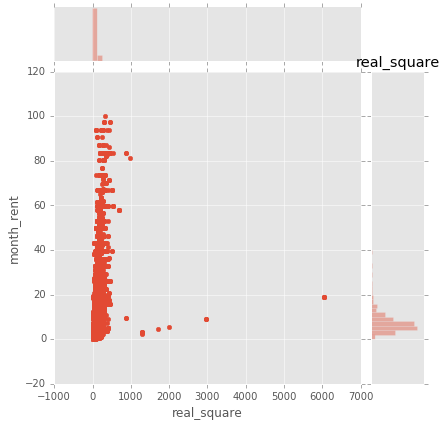

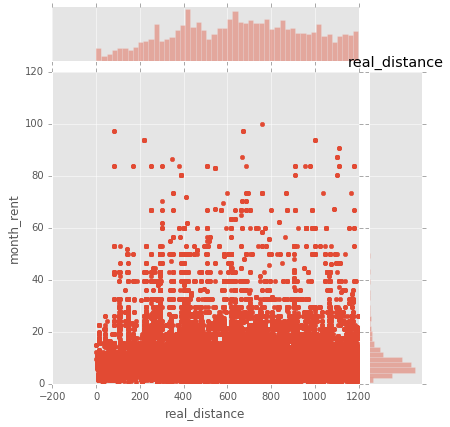

In [60]:
for i in discrete_cols:
    sns.jointplot(x=i, y="month_rent", data=train)
    plt.title(i)

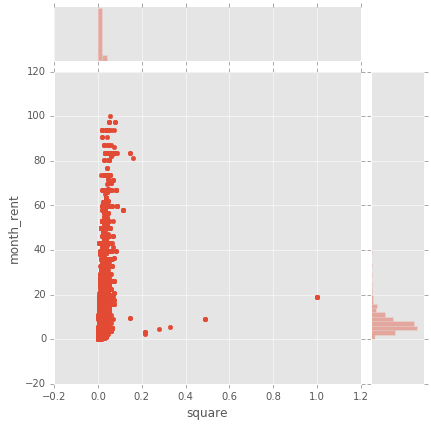

In [109]:
sns.jointplot(x="square", y="month_rent", data=train)

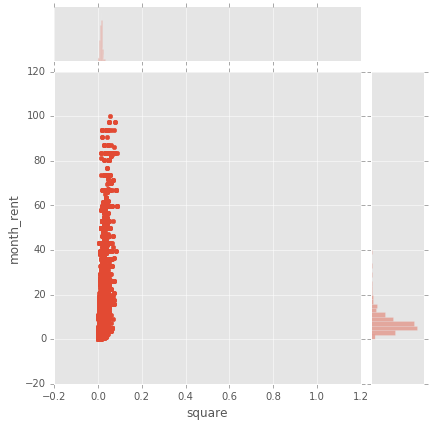

In [111]:
#train.loc[train["square"]>=0.1,"square"] = train.loc[train["square"]<0.1,"square"].mean()
sns.jointplot(x="square", y="month_rent", data=train,xlim=[-0.2,1.2])


In [121]:
train.loc[train["square"]>=0.1,"square"].shape

(25,)

In [93]:
train.loc[train["square"]>0.1,"square"]

(25,)

In [61]:
train.columns

Index(['time', 'department', 'rent_num', 'floor', 'total_floor', 'square',
       'direction', 'living_state', 'num_bedroom', 'num_living_room',
       'num_bath_room', 'rent_type', 'district', 'position', 'metro_line',
       'station', 'distance', 'decoration', 'month_rent', 'real_rent_num',
       'real_total_floor', 'real_square', 'real_distance'],
      dtype='object')

In [62]:
category_cols = list(set(train.columns.tolist()) - set(discrete_cols))

In [63]:
category_cols

['district',
 'floor',
 'num_bedroom',
 'rent_type',
 'num_living_room',
 'position',
 'direction',
 'decoration',
 'time',
 'month_rent',
 'station',
 'department',
 'num_bath_room',
 'living_state',
 'metro_line']

In [64]:
train["department"].nunique()

5547

In [65]:
common_department = set(train["department"]) &set(test["department"])

In [66]:
len(common_department)/test["department"].nunique()

0.9100946372239748

In [67]:
len(common_department)/train["department"].nunique()

0.6241211465657112

In [68]:
depart_ls = list(train["department"].value_counts().head(20).index)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

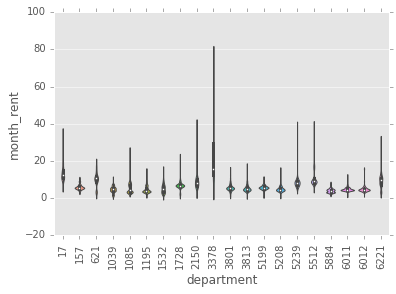

In [69]:
sns.violinplot(x="department",y="month_rent",data =  train[train["department"].isin(depart_ls)])
plt.xticks(rotation=90)

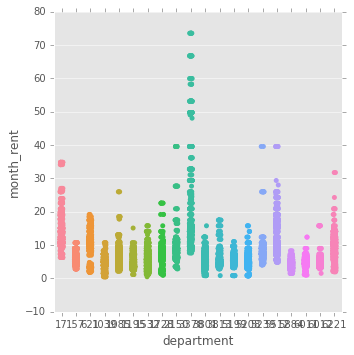

In [72]:
sns.catplot(x="department",y="month_rent",data = train[train["department"].isin(depart_ls)])

In [122]:
train["log_month_rent"] = train["month_rent"].map(lambda x:np.log(x+0.000001))

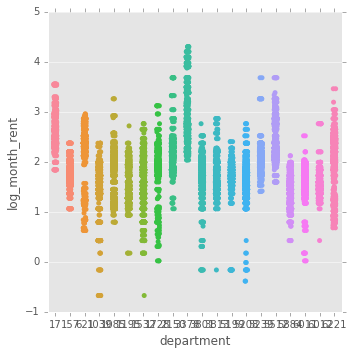

In [123]:
sns.catplot(x="department",y="log_month_rent",data = train[train["department"].isin(depart_ls)])

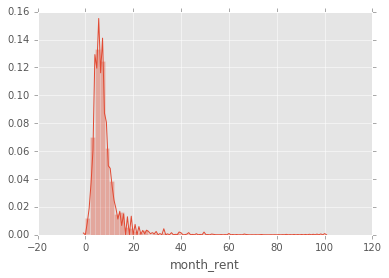

In [124]:
sns.distplot(train["month_rent"])

In [130]:
train["month_rent"].skew()

4.61873552901576

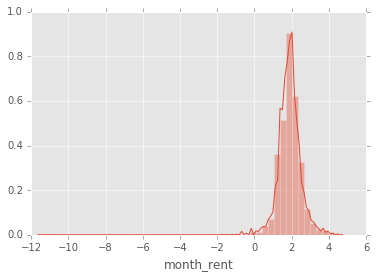

In [125]:
sns.distplot(np.log(train["month_rent"]+0.00001))

In [131]:
np.log(train["month_rent"]+0.00001).skew()

-0.05332130762142983

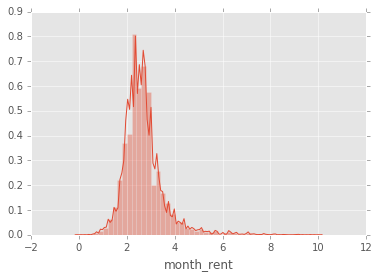

In [128]:
sns.distplot(np.sqrt(train["month_rent"]))

In [132]:
np.sqrt(train["month_rent"]).skew()

2.0001556851850113

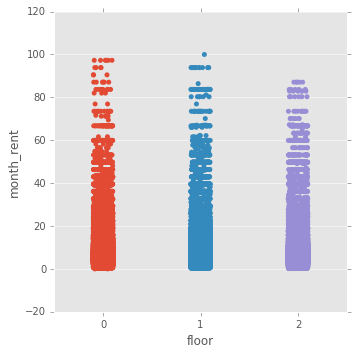

In [133]:
sns.catplot(x="floor",y="month_rent",data = train)

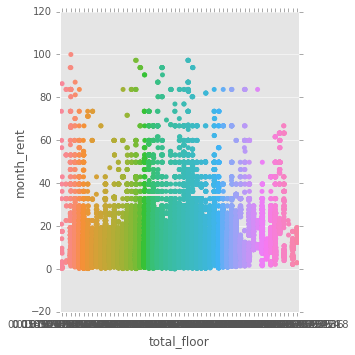

In [137]:
sns.catplot(x="total_floor",y="month_rent",data = train)

In [140]:
train["real_total_floor"] = train["total_floor"].map(getTotalFloor)

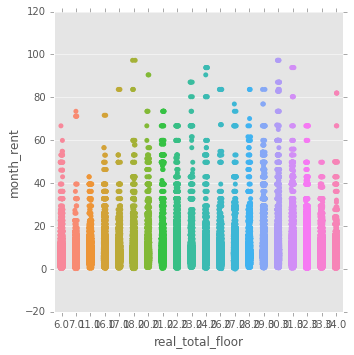

In [152]:
a = train["real_total_floor"].value_counts().head(20).index
sns.catplot(x="real_total_floor",y="month_rent",data = train[train["real_total_floor"].isin(a)])

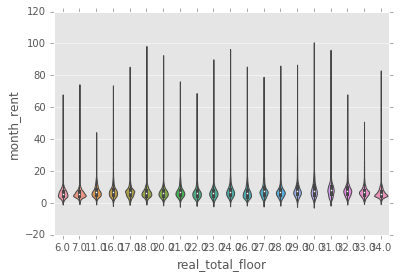

In [153]:
sns.violinplot(x="real_total_floor",y="month_rent",data = train[train["real_total_floor"].isin(a)])

In [160]:
train["floor2"] = train["floor"]/train["real_total_floor"]
#sns.violinplot(x="floor2",y="month_rent",data = train[train["real_total_floor"].isin(a)])
train["is_top"] = train.apply(lambda x:1 if x["floor"]==x["real_total_floor"] else 0,axis=1)

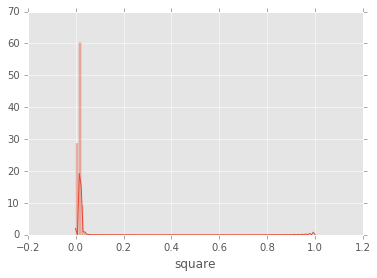

In [168]:
sns.distplot(train["square"],bins=100)

In [169]:
train["square"].skew()

50.793256950720064

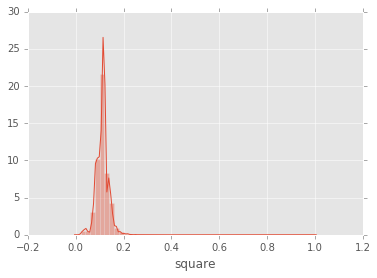

In [171]:
sns.distplot(np.sqrt(train["square"]))

In [172]:
np.sqrt(train["square"]).skew()

1.5348805900003588

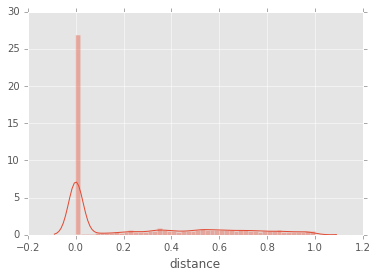

In [176]:
sns.distplot(train["distance"].fillna(0))

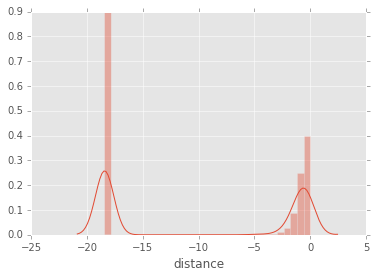

In [177]:
sns.distplot(np.log(train["distance"].fillna(0)+0.00000001))